<a href="https://colab.research.google.com/github/matpereira/Tp3-Grupo10/blob/main/Ejercicio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduccion**
Se utiliza un algoritmo para aplicar el filtro de contraste a una imagen (contrast-filter). 


# **2. Armado del Ambiente**

Para preparar el ambiente de ejecución, se debe cargar la url de una imagen, para que, luego, mediante el comando !wget se pueda obtener la imagen en formato .jpg.
Finalmente se instala pycuda para poder acceder a la API de CUDA desde Python y así lograr la comunicación entre el CPU y el GPU

In [50]:
# Especifique la URL de la imagen:
url_imagen = "https://www.gratistodo.com/wp-content/uploads/2017/09/Fondo-playa-paradisiaca-bora-bora-1.jpg" #@param {type:"string"}

# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg

!pip install pycuda

%matplotlib inline
from datetime import datetime
# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

--2021-07-04 19:57:42--  https://www.gratistodo.com/wp-content/uploads/2017/09/Fondo-playa-paradisiaca-bora-bora-1.jpg
Resolving www.gratistodo.com (www.gratistodo.com)... 104.21.234.9, 104.21.234.8, 2606:4700:3038::6815:ea08, ...
Connecting to www.gratistodo.com (www.gratistodo.com)|104.21.234.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223764 (219K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 218.52K  --.-KB/s    in 0.02s   

2021-07-04 19:57:42 (9.48 MB/s) - ‘imagen.jpg’ saved [223764/223764]



# **3. Desarrollo CPU**
Se agregan los import de numpy y de Image, para poder manejar las imágenes como arrays.

Se define el contraste deseado en una variable llamada “contraste”. Y luego se realiza la conversión con la siguiente fórmula

       `c = (100.0 + contraste)/100.0`

Luego esa variable c es elevada al cuadrado, para obtener el escalar que se le aplicará a RGB de cada pixel de la imagen y así aplicar el filtro de contraste.
Utilizando la biblioteca numpy, se transforma la imagen obtenida en la sección anterior en una matriz y se genera un nuevo array vacío para almacenar la imagen resultante. Luego se recorre la estructura matricial con un for, para poder ir aplicando, pixel por pixel el filtro de contraste, en cada uno de sus componente, Rojo, Verde y Azul.

La fórmula que aplicamos para aplicar el filtro es la siguiente:

        `NuevoPixel = (TonoDeGris / MaximoContraste) * 255.`


El pixel debe ser normalizado para poder aplicar el valor de contraste “c”. Para poder normalizar el pixel se divide su valor por el máximo valor posible (255) y así se obtiene un valor entre 0 y 1. Luego se le resta 0.5, se lo multiplica por c y se le suma 0.5. Finalmente, se lo multiplica por 255 para convertir ese resultado en un valor adecuado para la imagen. En caso de que dé un valor menor a cero o mayor a 255, se setea el valor de ese pixel en un valor límite.

Estas instrucciones son ejecutadas secuencialmente por el CPU. 

Imagen del filtro: imagen.jpg -RGB- [1600, 1000]
Tiempo de conversión de imagen: 20868.385 [ms]
Tiempo Total: 20960.352 [ms]


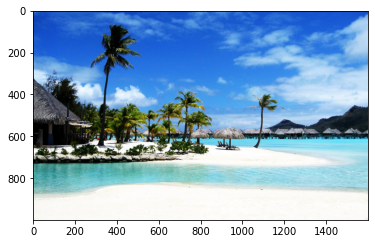

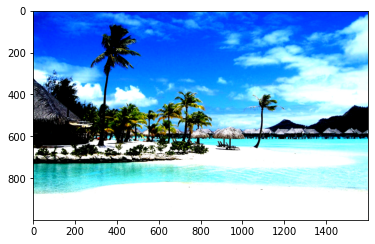

In [54]:
tiempo_total_CPU = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

contraste=30
c = (100.0 + contraste) / 100.0
c*= c

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# Optengo las proporsiones de la imagen. 
img_ancho, img_alto = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype( numpy.int32() )

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_picR_cpu = numpy.empty_like( img_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_pic_cpu )

tiempo_img_CPU = datetime.now()

# Convierto la imagen a escala de grises
for y  in range( 0, img_alto ):
  for x in range( 0, img_ancho ):
#    print( x, y, img_pic_cpu[x][y] )
    pixel_R, pixel_G, pixel_B = img_pic_cpu[y][x]
    r2=((((pixel_R/255.0)-0.5)*c)+0.5)*255.0;
    if r2 > 255:
       r2=255
    if r2 < 0:
      r2=0

    g2=((((pixel_G/255.0)-0.5)*c)+0.5)*255.0;
    if g2 > 255:
       g2=255
    if g2 < 0:
      g2=0

    b2=((((pixel_B/255.0)-0.5)*c)+0.5)*255.0;
    if b2 > 255:
       b2=255
    if b2 < 0:
      b2=0

    img_picR_cpu[y][x] = [r2, g2, b2]

tiempo_img_CPU = datetime.now() - tiempo_img_CPU

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_picR_cpu )

tiempo_total_CPU = datetime.now() - tiempo_total_CPU

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img_CPU   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total_CPU ), "[ms]" )

# **4. Desarrollo GPU**

Para utilizar el GPU primero se debe importar las bibliotecas de pycuda y numpy.
Luego se transforma la imagen en una matriz y se debe reservar la memoria del GPU para poder almacenar la matriz imagen y la matriz resultado, utilizando el comando cuda.mem_alloc() y luego se copian las matrices a la memoria del GPU usando cuda.memcpy(). 

Luego se genera una función global kernel que será ejecutada en la GPU, donde se utiliza la misma fórmula explicada anteriormente, pero en este caso, los píxeles de la imagen serán tratados por medio de hilos. Esa función será crosscompilada en la GPU.

Al momento de ejecutar la función en la GPU, se debe definir la cantidad de hilos que se utilizarán para ejecutar.

Luego, el CPU debe obtener la imagen resultado que se obtuvo de la ejecución del algoritmo en la GPU, con el comando cuda.memcpy() nuevamente.


Imagen del filtro: imagen.jpg -RGB- [1600, 1000]
Thread: [ 16 , 19  ], Bloque : [ 100 , 53 ]
Total de Thread: [ 1600 , 1007  ]  =  1611200


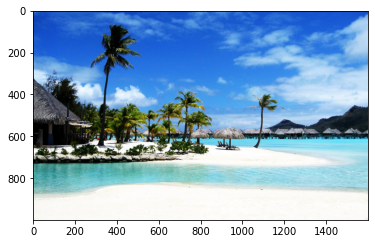

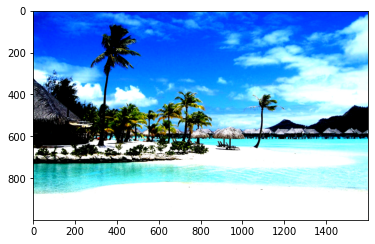

In [59]:

%matplotlib inline
from datetime import datetime
tiempo_total_GPU = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R )
{
   int contraste = 30 ;
   float c = (100.0f + contraste ) / 100.0f;
   c*= c;
   float r =0;
   float g = 0;
   float b = 0;

  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float fGris = 0.0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el color gris para el pixel a partir de los componentes.

    r= (((( (float)img_O[(idx+(idy*ancho))*3  ] / 255.0f) -0.5f) *c) +0.5f ) * 255;
    if  (r > 255) r=255;
    if (r< 0) r=0;

    g= (((( (float)img_O[((idx+(idy*ancho))*3)+1] / 255.0f) -0.5f) *c) +0.5f ) * 255;
    if  (g > 255) g=255;
    if (g< 0) g=0;

    b= (((( (float)img_O[((idx+(idy*ancho))*3)+2] / 255.0f) -0.5f) *c) +0.5f ) * 255;
    if  (b > 255) b=255;
    if (b< 0) b=0;

    // Escribo el color del pixel.

     img_R[(idx+(idy*ancho))*3  ] = (int) r;
    img_R[(idx+(idy*ancho))*3+1] = (int) g;
    img_R[(idx+(idy*ancho))*3+2] = (int) b;
 }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")


dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img_GPU = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img_GPU = datetime.now() - tiempo_img_GPU

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total_GPU = datetime.now() - tiempo_total_GPU

# **5. Metricas**

En esta sección se muestra el tiempo que tardó el CPU en aplicar el filtro de contraste y el tiempo que tardó el GPU en realizar la misma operación. 

In [58]:
print( "Tiempo de conversión de imagen CPU:", tiempo_en_ms( tiempo_img_CPU   ), "[ms]" )
print( "Tiempo Total CPU:",                   tiempo_en_ms( tiempo_total_CPU ), "[ms]" )
print("-"*8)
print("Tiempo de conversión de imagen GPU  : ", tiempo_en_ms( tiempo_img_GPU ), "[ms]" )
print("Tiempo TOTAL GPU: ", tiempo_en_ms( tiempo_total_GPU ), "[ms]" )

Tiempo de conversión de imagen CPU: 20868.385 [ms]
Tiempo Total CPU: 20960.352 [ms]
--------
Tiempo de conversión de imagen GPU  :  0.173 [ms]
Tiempo TOTAL GPU:  112.296 [ms]


# **6. Conclusiones**
Se puede apreciar en base a las métricas obtenidas que la ejecución por CPU-GPU es aproximadamente 120 veces mas rápida que ejecutar el mismo algortimo solo en CPU.

Es muy notorio el beneficio de la ejecución de los hilos paralelos en el GPU para optimizar los tiempos de ejecución.

# **Bibliografias**

https://www.youtube.com/watch?v=F-01IEflcz8

https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20GPU.ipynb

https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20CPU.ipynb